#Sun or Moon Classifier

##Install Dependencies

In [ ]:
!pip3 install fastai bing-image-downloader

##Create Your Dataset

###Download Images from the Bing Search Engine

**keyword (*str*):** The keyword to search for images.

**max_images (*int*):** The maximum number of images to download.

**path (*str*):** The output directory to save the downloaded images.

In [3]:
from bing_image_downloader import downloader
from fastcore.all import *
from fastai.vision.all import *

def download_images(keyword, max_images, path):
  print(f'Downloading {keyword} images')

  downloader.download(
      keyword,
      limit = max_images,
      output_dir = path,
      verbose = False
  )

####Get a list of all Filenames in a Directory
**direcotry(*str*)** - name of directory

In [4]:
def get_all_paths(directory):
  return [path for path in glob.glob(directory, recursive=True) if os.path.isfile(path)]

###View Sample Data

[%] Downloading Images to /content/test/sun


[%] Done. Downloaded 2 images.


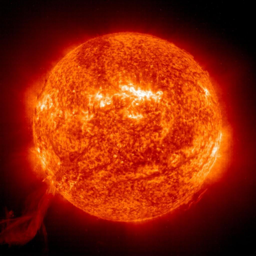

In [6]:
"""
  View a sample image of a sun
"""

download_images('sun', 2, 'test')
sun_image_paths = get_all_paths("test/sun/*")

Image.open(sun_image_paths[0]).to_thumb(256,256)

[%] Downloading Images to /content/test/moon


[%] Done. Downloaded 2 images.


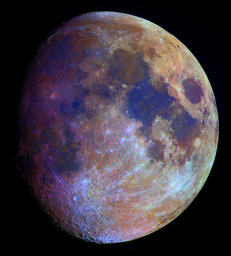

In [7]:
"""
  View a sample image of a moon
"""

download_images('moon', 2, 'test')
moon_image_paths = get_all_paths("test/moon/*")

Image.open(moon_image_paths[0]).to_thumb(256,256)

##Making the Actual Dataset



*   Download Images for each label
*   Resize them to 400px so that we can train the model with images that are of the same size, it makes the inputs to the model uniform

In [8]:
path = Path('train')

labels = 'sun', 'moon'

for label in labels:
  download_images(label, 30, path)
  resize_images(path/label, max_size = 400, dest = path/label)

  download_images(f'{label} scenery', 30, path)
  resize_images(path/f'{label} scenery', max_size = 400, dest = path/f'{label} scenery')

[%] Downloading Images to /content/train/sun
[Error]Invalid image, not saving http://i221.photobucket.com/albums/dd39/tonyedwards2007/sun.gif

[!] Issue getting: http://i221.photobucket.com/albums/dd39/tonyedwards2007/sun.gif
[!] Error:: Invalid image, not saving http://i221.photobucket.com/albums/dd39/tonyedwards2007/sun.gif

[!] Issue getting: https://thenypost.files.wordpress.com/2013/12/sun.jpg
[!] Error:: HTTP Error 404: Not Found
[Error]Invalid image, not saving https://ferrebeekeeper.files.wordpress.com/2010/08/sun.jpg

[!] Issue getting: https://ferrebeekeeper.files.wordpress.com/2010/08/sun.jpg
[!] Error:: Invalid image, not saving https://ferrebeekeeper.files.wordpress.com/2010/08/sun.jpg

[!] Issue getting: https://weknowyourdreams.com/images/sun/sun-01.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)>


[%] Done. Downloaded 30 images.
[%] Downloading Images to /content/train/sun s

### Remove the corrupt images
Remove images that are corrupt to have a cleaner dataset for training the model

In [9]:
failed = verify_images(get_image_files(path))

# Path.unlink deletes the image from the folder
failed.map(Path.unlink)

print(f'{len(failed)} corrupt images found')

0 corrupt images found


## Training the Model


In [10]:
"""
Returns the label/category that belongs to the image by checking the name
of it's parent directory.
"""
def get_label(path):
  folder = Path(path).parent.name
  return "moon" if ("moon" in folder) else "sun"

###Load and Preprocess the data
The DataBlock class is used to define the configuration for the data loading and processing pipeline.

**blocks:** A tuple specifying the types of data blocks used. In this case, it consists of ImageBlock and CategoryBlock, representing the image and category (label) blocks, respectively.

**get_items:** A function that returns a list of items (in this case, image files) to be processed. The get_image_files function is used, which retrieves all image files in the specified path.

**splitter:** Specifies how to split the data into training and validation sets. RandomSplitter randomly splits 20% of the data for testing and 80% for training.

**get_y:** A function that assigns the labels to the items. In this case, the get_label function is used, which determines the label based on the parent folder name of the image file.

**item_tfms:** A list of transformations to be applied on each image. In this case, Resize is used to resize the images to a size of 192x192 pixels using the "squish" method.

Finally, the dataloaders method is called on the DataBlock object, passing the path (the directory containing the image files) and bs=32 (the batch size) as arguments. This method creates the dataloaders, which are used to load the data in batches for training and testing.

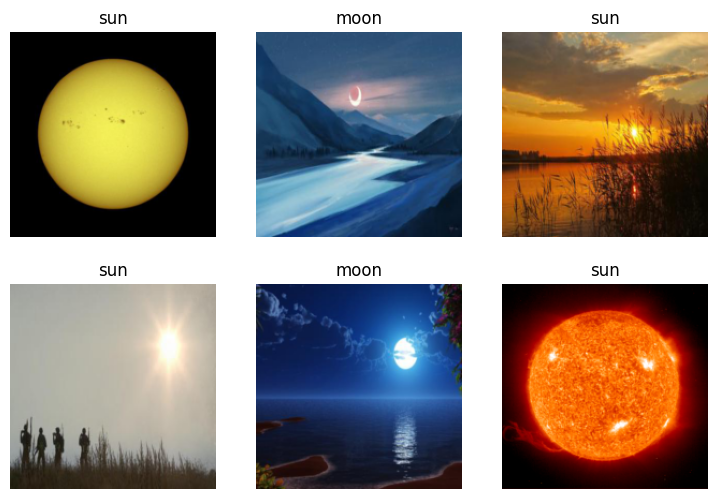

In [11]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

data.show_batch(max_n=6)

###Train the Model
We train our model with our own dataset on top of a pre trained model this process is called transfer learning.


> **NOTE:** ResNet-18 is a convolutional neural network.
> It consists of 18 layers, making it a deep neural network.
> ResNet-18 is trained on more than a million images.
> It can classify images into 1000 different categories.

In [12]:
learn = vision_learner(data, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 296MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.195917,1.235257,0.583333,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.377618,0.594310,0.291667,00:23
1,0.331800,0.278174,0.083333,00:23
2,0.250675,0.173743,0.083333,00:21
3,0.193329,0.111271,0.041667,00:19
4,0.156945,0.087376,0.041667,00:20


The "fine-tune" function is used to train the model on data. It has a parameter called "epochs" which determines how many times the model will be trained on the data.

> **_NOTE:_**
To improve the model's performance, you can increase the number of epochs.
By doing so, the model gets more opportunities to learn from the data and reduce the error rate.
The goal is to keep increasing the number of epochs until you achieve a very low error rate, indicating that the model has learned the data patterns effectively.


##Testing the Model

In [13]:
def predict_label(path):
  label,_,probs = learn.predict(PILImage.create(path))
  print(f"Prediction for {path}")
  Image.open(path).resize((256, 256)).show()
  print(f"This is a {label}.")
  print(f"Probability it's a moon: {probs[0]:.4f}")
  print(f"Probability it's a sun: {probs[1]:.4f}\n")

Prediction for test/moon/Image_2.jpg


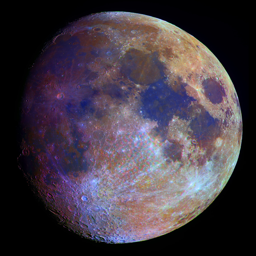

This is a moon.
Probability it's a moon: 0.9913
Probability it's a sun: 0.0087



Prediction for test/moon/Image_1.jpg


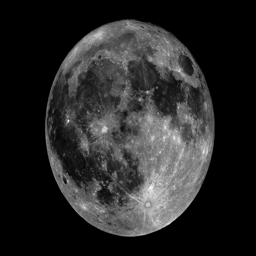

This is a moon.
Probability it's a moon: 0.9999
Probability it's a sun: 0.0001



Prediction for test/sun/Image_2.jpg


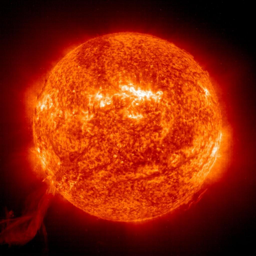

This is a sun.
Probability it's a moon: 0.0001
Probability it's a sun: 0.9999



Prediction for test/sun/Image_1.gif


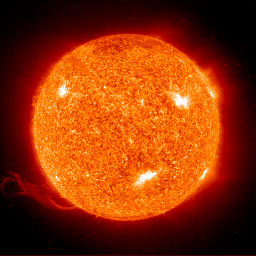

This is a sun.
Probability it's a moon: 0.0001
Probability it's a sun: 0.9999



In [14]:
"""
We Test the model by passing all images from the test folder into the model
and find the label for each image
"""
file_paths = get_all_paths('test/**')

for file in file_paths:
  predict_label(file)

In [195]:
# !rm -rf test train